In [1]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import statsmodels.formula.api as smf
from osgeo import gdal
from rasterstats import zonal_stats
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm

plt.style.use("ggplot")

# Estimate lake volumes for 1000 Lakes

Using the statistical model developed [here](https://nbviewer.org/github/NIVANorge/teotil3/blob/main/notebooks/development/T2-4a_estimate_lake_volumes.ipynb).

In [2]:
# DEM resolution for zonal stats
dtm_res = 10

In [3]:
# Read 1000 Lakes IDs from AM
am_1k_lakes_df = pd.read_excel("../data/am_1000_lakes_ids.xlsx")
am_1k_lakes_df.drop_duplicates(subset=["station_id"], inplace=True)
print(len(am_1k_lakes_df), "lakes.")
am_1k_lakes_df.head()

1003 lakes.


,station_id,station_code,station_name,lat,lon,nve_vatnlnr
0,26154,1840-601,Kjemåvatn,66.750538,15.407868,806
1,26150,831-501,Brårvatn,59.297470,7.714567,14277
2,26152,1228-501,Steinavatn,59.856352,6.571981,1705
3,26107,1114-1-34,Lomstjørni,58.676223,6.083236,20451
4,26070,221-1-2,Langtjern,59.808643,11.850274,3208


In [4]:
# Read NVE lake dataset
data_year = 2022
data_fold = f"/home/jovyan/shared/teotil3/core_data_june_{data_year}"
nve_gdb = os.path.join(data_fold, "hydrology", "NVEData.gdb")

# All lakes
lake_gdf = gpd.read_file(nve_gdb, driver="fileGDB", layer="Innsjo").to_crs("epsg:25833")
cols = [
    "vatnLnr",
    "navn",
    "vassdragsnummer",
    "vassdragsomradeNr",
    "hoyde_moh",
    "arealInnsjo_km2",
    "arealNedborfelt_km2",
    "dybdekart",
    "geometry",
]
new_cols = [
    "vatnLnr",
    "name",
    "regine",
    "vassom",
    "elev_m",
    "area_km2",
    "catch_area_km2",
    "vol_est_avail",
    "geometry",
]
lake_gdf = lake_gdf[cols]
lake_gdf.columns = new_cols
lake_gdf["vol_est_avail"].replace({None: 0, "J": 1}, inplace=True)

# Remove weird values in lakes database
lake_gdf.dropna(subset=["vatnLnr", "regine", "vassom"], inplace=True)
lake_gdf = lake_gdf.query("(area_km2 > 0) and (catch_area_km2 > 0)")
lake_gdf.drop_duplicates(subset="vatnLnr", keep=False, inplace=True)

lake_gdf.head()

,vatnLnr,name,regine,vassom,elev_m,area_km2,catch_area_km2,vol_est_avail,geometry
0,505,Aahkanjaevrie,155.D1B,155,718.0,3.4267,16.06,0,"MULTIPOLYGON (((446342.960 7294575.240, 446352..."
1,36452,Svartvatnet,116.B,116,419.0,0.0494,0.37,0,"MULTIPOLYGON (((191800.740 7031154.190, 191874..."
2,81309,Gåntjern,002.ACB,002,207.0,0.0397,0.36,0,"MULTIPOLYGON (((301121.050 6596125.670, 301117..."
3,101659,None,119.62B,119,NaN,0.0059,0.08,0,"MULTIPOLYGON (((229911.430 7049804.700, 229920..."
4,143542,None,116.B,116,NaN,0.0058,0.05,0,"MULTIPOLYGON (((192887.790 7031240.180, 192883..."


In [5]:
# Filter NVE dataset to just include the 1000 Lakes
nve_lake_ids = am_1k_lakes_df["nve_vatnlnr"].tolist()
lake_gdf = lake_gdf.query("vatnLnr in @nve_lake_ids")
print(len(lake_gdf), "lakes matched in NVE data.")
lake_gdf.head()

1001 lakes matched in NVE data.


,vatnLnr,name,regine,vassom,elev_m,area_km2,catch_area_km2,vol_est_avail,geometry
803,3954,Vesle Otten,002.EC4A,002,NaN,0.0493,5.76,0,"MULTIPOLYGON (((300295.390 6707479.410, 300280..."
1114,3438,Nordre Torgrimsbutjern,314.A42,314,111.0,0.0817,1.54,0,"MULTIPOLYGON (((316177.910 6584020.520, 316181..."
1173,14900,None,021.EAZ,021,1114.0,0.0370,0.32,0,"MULTIPOLYGON (((63807.050 6578679.490, 63809.7..."
1744,52936,None,302.6B,302,NaN,0.0256,3.46,0,"MULTIPOLYGON (((702854.170 7663655.640, 702857..."
1831,52329,None,206.A2,206,883.0,0.1557,1.36,0,"MULTIPOLYGON (((740753.660 7720325.900, 740753..."


In [6]:
# Coefficients for best model copied from other notebook
bias_fac = 1.130489
beta_0 = 0.213241
reg_par_dict = {
    "nve_area_km2": 1.400965,
    "aspect_ratio": -0.185160,
    "slp_mean": 0.974396,
}

In [7]:
# Get depth data for all lakes
stats_csv = r"https://raw.githubusercontent.com/NIVANorge/teotil3/main/data/lake_volume_characteristics_10m_dem.csv"
stats_df = pd.read_csv(stats_csv)
cols = ["vatnLnr", "vol_Mm3", "res_time_yr"]
stats_df = stats_df[cols]

# Join to lakes database
lake_gdf = lake_gdf.merge(stats_df, on="vatnLnr", how="left")

# Check all lakes have valid areas
assert pd.isna(lake_gdf["area_km2"]).sum() == 0
assert (lake_gdf["area_km2"] <= 0).sum() == 0

# Calculate aspect ratio
lake_gdf["area2_km2"] = lake_gdf["geometry"].area / 1e6
lake_gdf["perim_km"] = lake_gdf["geometry"].length / 1e3
lake_gdf["width_km"] = (
    lake_gdf["perim_km"]
    - (lake_gdf["perim_km"] ** 2 - 16 * lake_gdf["area2_km2"]) ** 0.5
) / 4
lake_gdf["length_km"] = (
    lake_gdf["perim_km"]
    + (lake_gdf["perim_km"] ** 2 - 16 * lake_gdf["area2_km2"]) ** 0.5
) / 4

lake_gdf["aspect_ratio"] = lake_gdf["length_km"] / lake_gdf["width_km"]
lake_gdf["aspect_ratio"].fillna(1, inplace=True)
lake_gdf["width_km"].fillna(lake_gdf["area2_km2"]**0.5, inplace=True)

# assert np.iscomplex(lake_gdf["width_km"]).sum() == 0
# assert np.iscomplex(lake_gdf["length_km"]).sum() == 0

del lake_gdf["length_km"], lake_gdf["area2_km2"], lake_gdf["perim_km"]
# lake_gdf.dropna(subset="aspect_ratio", inplace=True)

# Buffer based on width
buffer = 0.5 * 1000 * lake_gdf["width_km"]
temp_fold = r"/home/jovyan/shared/01_datasets/spatial/temp"

reg_list = lake_gdf["regine"].unique().tolist()
vassom_list = lake_gdf["vassom"].unique().tolist()
print(
    f"The lakes dataset includes lakes from {len(reg_list)} regines in {len(vassom_list)} vassdragsområder."
)

# Buffer lakes and clip to create zone dataset
zone_gdf = lake_gdf.copy()
zone_gdf["geometry"] = zone_gdf.buffer(buffer)
zone_gdf = zone_gdf.overlay(lake_gdf, how="difference")
zone_gdf.head()

The lakes dataset includes lakes from 939 regines in 194 vassdragsområder.


,vatnLnr,name,regine,vassom,elev_m,area_km2,catch_area_km2,vol_est_avail,geometry,vol_Mm3,res_time_yr,width_km,aspect_ratio
0,3954,Vesle Otten,002.EC4A,002,NaN,0.0493,5.76,0,"POLYGON ((300127.034 6707636.636, 300122.399 6...",NaN,NaN,0.150354,2.181875
1,3438,Nordre Torgrimsbutjern,314.A42,314,111.0,0.0817,1.54,0,"POLYGON ((315966.341 6583873.350, 315960.391 6...",NaN,NaN,0.112500,6.453040
2,14900,None,021.EAZ,021,1114.0,0.0370,0.32,0,"MULTIPOLYGON (((63787.947 6578686.118, 63790.6...",NaN,NaN,0.040440,22.631953
3,52936,None,302.6B,302,NaN,0.0256,3.46,0,"POLYGON ((702837.286 7663629.527, 702834.877 7...",NaN,NaN,0.062192,6.606328
4,52329,None,206.A2,206,883.0,0.1557,1.36,0,"POLYGON ((740654.620 7720318.156, 740654.535 7...",NaN,NaN,0.198744,3.941330


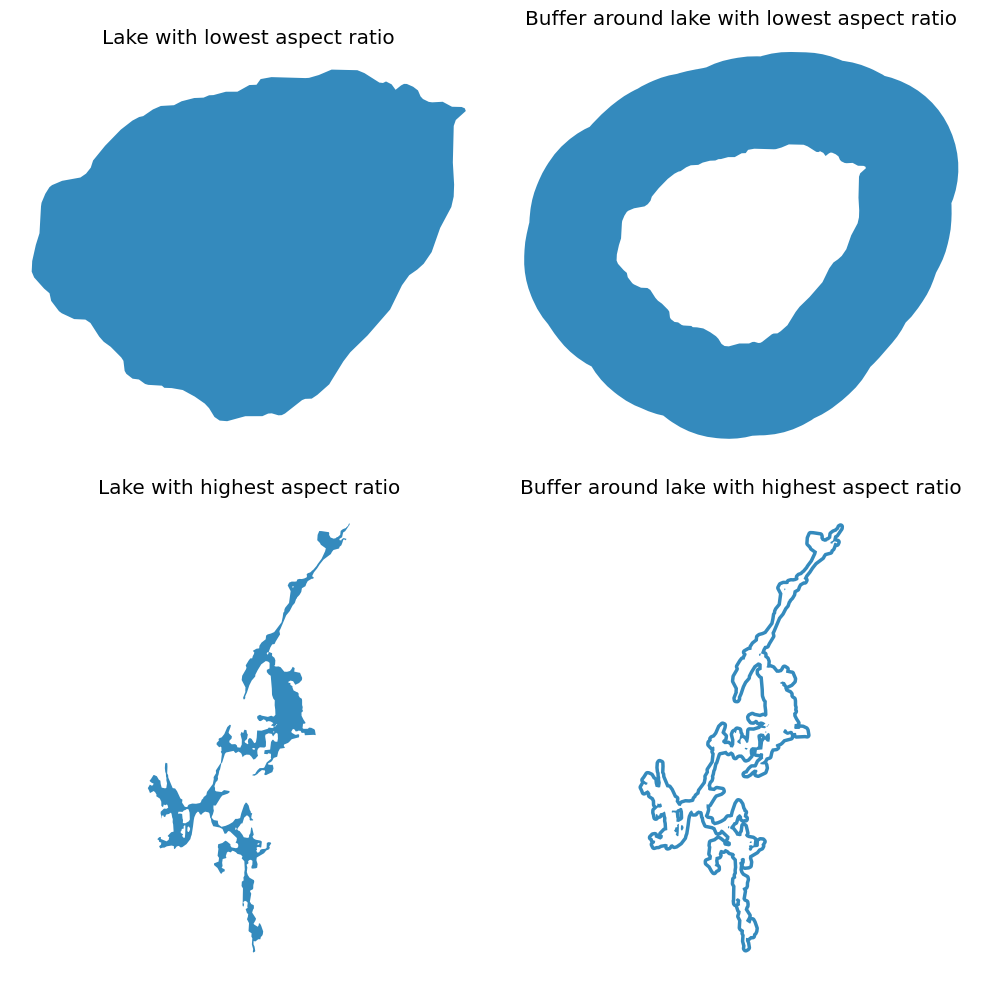

In [9]:
# Plot example buffer
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
axes = axes.flatten()

lake_gdf.sort_values("aspect_ratio").iloc[[0]].plot(ax=axes[0])
zone_gdf.sort_values("aspect_ratio").iloc[[0]].plot(ax=axes[1])
lake_gdf.sort_values("aspect_ratio").iloc[[-1]].plot(ax=axes[2])
zone_gdf.sort_values("aspect_ratio").iloc[[-1]].plot(ax=axes[3])

axes[0].set_title("Lake with lowest aspect ratio")
axes[1].set_title("Buffer around lake with lowest aspect ratio")
axes[2].set_title("Lake with highest aspect ratio")
axes[3].set_title("Buffer around lake with highest aspect ratio")

for ax in axes:
    ax.axis("off")

plt.tight_layout()

In [10]:
# Zonal stats for catchments
stats = [
    "mean",
]

# Process each vassom in turn
df_list = []
for vassom in tqdm(vassom_list):
    dem_path = f"/home/jovyan/shared/01_datasets/spatial/dtm_merged_utm33/dtm_{dtm_res}m/by_vassom/dtm/vassom_{vassom}_{dtm_res}m_dtm.tif"
    slp_path = os.path.join(temp_fold, f"vassom_{vassom}_{dtm_res}m_slope.tif")
    vassom_zone_gdf = zone_gdf.query("vassom == @vassom").dropna(subset="geometry")

    # Calcule slopes
    gdal.DEMProcessing(
        slp_path,
        dem_path,
        "slope",
        alg="Horn",  # 'Horn' or 'ZevenbergenThorne'
        slopeFormat="degree",  # 'degree' or 'percent'
        creationOptions=["compress=lzw", "BIGTIFF=YES", "tiled=True"],
    )

    # Zonal stats
    idx_cols = [i for i in vassom_zone_gdf.columns if i != "geometry"]
    slp_stats = [f"slp_{i}" for i in stats]
    cols = idx_cols + slp_stats + ["geometry"]
    slp_res_df = pd.DataFrame(
        zonal_stats(
            vectors=vassom_zone_gdf,
            raster=slp_path,
            stats=stats,
        )
    )

    # Tidy
    assert len(vassom_zone_gdf) == len(slp_res_df)

    for col in slp_res_df.columns:
        vassom_zone_gdf["slp_" + col] = slp_res_df[col].values

    vassom_zone_gdf = vassom_zone_gdf[cols]
    vassom_zone_gdf.dropna(subset=slp_stats, inplace=True)
    df_list.append(vassom_zone_gdf)
    os.remove(slp_path)

# Combine results
stats_gdf = pd.concat(df_list, axis="rows")

print("Slope characteristics derived for", len(stats_gdf), "lakes.")

  0%|          | 0/194 [00:00<?, ?it/s]

Slope characteristics derived for 1001 lakes.


In [11]:
# Estimate volumes
stats_gdf["nve_area_km2"] = stats_gdf["area_km2"]
stats_gdf["vol_est_Mm3"] = (10**beta_0) * bias_fac
reg_vars = reg_par_dict.keys()
for reg_var in reg_vars:
    stats_gdf["vol_est_Mm3"] = stats_gdf["vol_est_Mm3"] * (
        stats_gdf[reg_var] ** reg_par_dict[reg_var]
    )
del stats_gdf["nve_area_km2"]

RMSE for self-affine volume estimates with terrain characteristics and aspect ratio included: 942 Mm3.


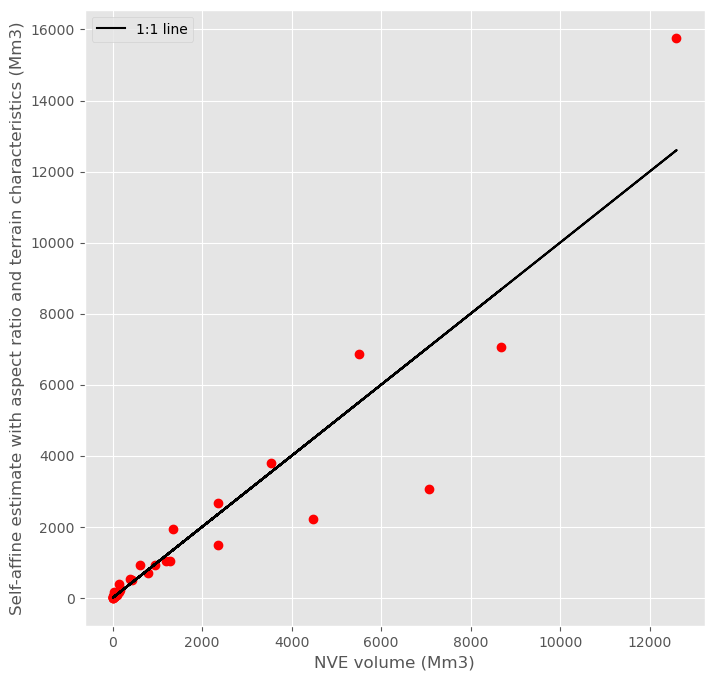

In [12]:
# Check results look reasonable
check_df = stats_gdf.dropna(subset="vol_Mm3").copy()
check_df = check_df.query("vatnLnr != 118")

rmse = mean_squared_error(check_df["vol_Mm3"], check_df["vol_est_Mm3"], squared=False)
print(
    f"RMSE for self-affine volume estimates with terrain characteristics and aspect ratio included: {rmse:.0f} Mm3."
)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(check_df["vol_Mm3"], check_df["vol_est_Mm3"], "ro")
ax.plot(check_df["vol_Mm3"], check_df["vol_Mm3"], "k-", label="1:1 line")
ax.set_xlabel("NVE volume (Mm3)")
ax.set_ylabel(
    "Self-affine estimate with aspect ratio and terrain characteristics (Mm3)"
)
ax.legend(loc="upper left")

In [13]:
# Use measured volumes where available and estimated volumes otherwise
stats_gdf["vol_Mm3"] = stats_gdf["vol_Mm3"].combine_first(stats_gdf["vol_est_Mm3"])
assert pd.isna(stats_gdf["vol_Mm3"]).sum() == 0
del stats_gdf["vol_est_Mm3"]
print(f"Volumes estimated for {len(stats_gdf)} lakes.")

Volumes estimated for 1001 lakes.


In [14]:
# Save to CSV
stats_csv = f"../data/lake_volume_estimates_1k_lakes_{dtm_res}m_dem.csv"
pd.DataFrame(stats_gdf.drop(columns="geometry")).to_csv(stats_csv, index=False)

stats_gdf.head()

,vatnLnr,name,regine,vassom,elev_m,area_km2,catch_area_km2,vol_est_avail,vol_Mm3,res_time_yr,width_km,aspect_ratio,slp_mean,geometry
0,3954,Vesle Otten,002.EC4A,002,NaN,0.0493,5.76,0,0.153702,NaN,0.150354,2.181875,6.848261,"POLYGON ((300127.034 6707636.636, 300122.399 6..."
9,4041,Tennungen,002.E2AB,002,298.0,0.2799,8.60,0,2.466976,NaN,0.223743,5.591496,11.643827,"POLYGON ((303237.985 6696154.329, 303240.181 6..."
22,32409,Urdtjønnet,002.DF1E,002,918.0,0.0653,3.51,0,0.117887,NaN,0.179621,2.023645,3.432578,"POLYGON ((240062.658 6847221.164, 240060.499 6..."
26,3981,Bundlitjennet,002.DAB3,002,NaN,0.0814,0.50,0,0.256921,NaN,0.126634,5.076083,6.624139,"POLYGON ((285707.464 6706051.603, 285705.297 6..."
31,3107,Heia,002.D1,002,183.0,0.5181,17.81,0,3.076215,NaN,0.128919,31.173602,8.352129,"MULTIPOLYGON (((288379.213 6649468.097, 288375..."
